# Cloud Logging Tutorial: Classification of Lung Nodules for Cancer

In this tutorial, we will guide you step-by-step through using the Obz AI python package to monitor and explain a machine learning model that classifies lung nodules (CT scans) as potentially cancerous or not.

For anomaly detection, we utilize a data inspection routine based on Gaussian Mixture Model (GMM) fitted on First Order Image Features. 
For explainable AI, we compute attention maps and class-discriminative attention maps (CDAMs).

**What will you learn?**

- How to apply a simple image classification model using sample medical images.
- How to log directly to the Obz AI cloud platform from your code.

First, let's install `obz` package if you haven't already installed it. Also let's install `gdown` to download pretrained weights and `medmnist` to download examples of lung nodules.

In [3]:
%pip install obzai
%pip install -q gdown
%pip install -q medmnist

/Users/ncc/GitHub/alethia-xai/obzai/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ncc/GitHub/alethia-xai/obzai/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/ncc/GitHub/alethia-xai/obzai/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


Import the necessary modules:

In [12]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch
import gdown
import os

# toy examples from medmnist
from medmnist import NoduleMNIST3D

Before you get started logging and visualizing data with the `ObzClient` from our Python library, you will need your unique API key. This key is required to securely connect your code to your account on our SaaS platform.

**Here's how to find your API key:**

1. **Log in to your Dashboard:**  
   Open your web browser and go to [Obz.AI](http://app.obz.ai/). Log in using your registered email and password.

2. **Navigate to the Settings section:**  
   After logging in, look for a menu item called "Settings". Click on it to access your API settings. Make sure to copy this key now — you will need it in the next steps.

In [5]:
# Security is important. Do not share your API token with anyone.
API_TOKEN:str = "your-api-token"

Before you can monitor or visualize the workings of your model using our library, you first need to define the model you want to track.

In this tutorial, we will use a Vision Transformer (ViT) model that has been previously trained and fine-tuned on lung nodules (LIDC) — meaning, the model has already learned to recognize patterns in medical images of lung nodules using a technique called self-supervised learning, specifically with the DINO backbone.

In [13]:
def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    
    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

Weights already exist at tuned_models/lidc_dino_s8.pth. Skipping download.


## Configure the ViT classifer based on DINO backbone

We are adding a binary classification head (see how ```torch.nn.Linear```) onto a DINO backbone.

In [14]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 1)
    
    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"

MODEL = DINO()
MODEL.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE)))
MODEL = MODEL.to(DEVICE).eval()

Next, let's prepare the datasets. In general, you will need two separate sets of images:

**Reference Dataset**: This dataset will be used to extract reference image features and to fit the outlier detection models. In ML, this may be a training dataset.

**Inference Dataset**: This dataset will be treated as incoming new data on which you want to perform outlier detection. In ML, this may be testing or validation dataset or any new samples in production.

For the tutorial case we will use LIDC-IDRI subset called: **Nodule MNIST**. This dataset is readily available via **MedMNIST** package.

In [16]:
# Transforms
def take_middle_slice(inpt: np.ndarray):
    """
    NoduleMNIST 3D contains whole nodule volumes, however for this tutorial
    we will utilize only central slice of each example.
    We repeat this slice 3 times, as model expects input to have 3 channels.
    """
    inpt = inpt.squeeze()
    X, Y, Z = inpt.shape
    slice_ = inpt[:, :, Z//2]
    slice_ = torch.Tensor(slice_).unsqueeze(dim=0).repeat(3,1,1)
    return slice_

TRANSFORMS = v2.Compose([v2.Lambda(take_middle_slice),
                         v2.Resize(size=(224,224))
                         ])

NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Datasets
data_dir = "./example_data"
os.makedirs(data_dir, exist_ok=True)
output_path = os.path.join(data_dir, filename)

## Reference data. We will use it as source of reference statistics and to "train" OutlierDetector.
ref_set = NoduleMNIST3D(root=data_dir, split="val", size=64, transform=TRANSFORMS, download=True)
## Inference data. We will use it as exemplary source of production data. 
inf_set = NoduleMNIST3D(root=data_dir, split="test", size=64, transform=TRANSFORMS)

# DataLoaders
ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(inf_set, batch_size=6, shuffle=True)

# Labels mapping
CLASS_NAMES = ["benign", "malignant"]

LOGIT2NAME = {
    0: "benign",
    1: "malignant",
}

Visualize the first 5 samples from ref_loader

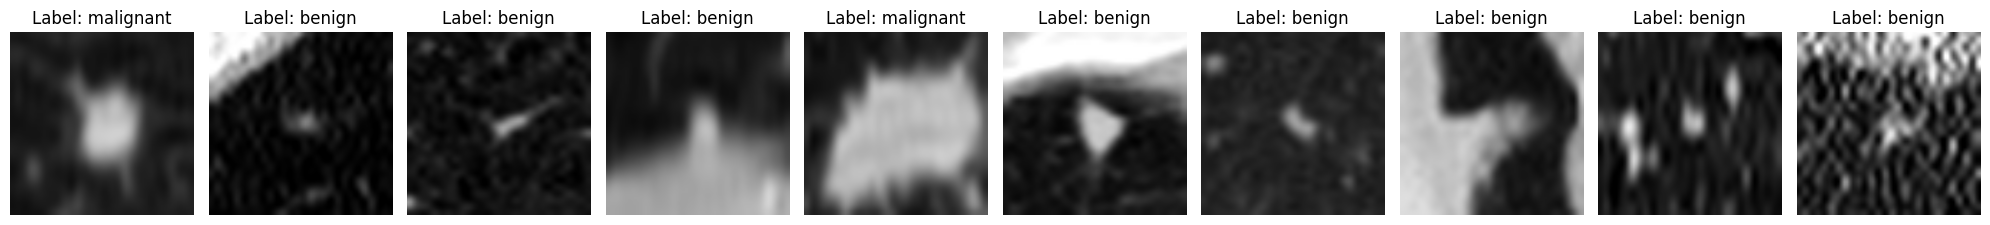

In [17]:
# Visualize the first 10 samples from ref_loader
# Get the first batch of samples
samples, labels = next(iter(ref_loader))

# Plot the first 10 samples
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    image = samples[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {CLASS_NAMES[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Using ObzClient to Explain and Monitor a AI Model

In this section, we'll show you how to set up and use the `ObzClient` to automatically log your data features and model explanation outputs to the Obz AI cloud platform.

### Local Usage

You can use the **Data Inspector Module** and **XAI Module** locally on your machine. To explore all the core features of these modules, please see the Jupyter notebook tutorials provided:
- [data_inspector_tutorial.ipynb](./data_inspector_tutorial.ipynb)
- [xai_tools_tutorial.ipynb](./xai_tools_tutorial.ipynb)

### Cloud Logging with ObzClient

To take full advantage of Obz AI, you can log your data features and model explanation outputs to the Obz AI cloud. This enables you to:
- Track and organize input features and outlier statistics.
- Store and visualize model explanations and results.
- Collaborate and share insights via the Obz dashboard.

### Step 1: Instantiate the Modules

Instantiate and fit an Outlier Detector from the `Data Inspector` Module for outlier detection:

In [18]:
from obzai.data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector

# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_components=3, outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader. 
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(ref_loader)

Instantiate your chosen explainability method from the `XAI Tool` Module:

In [19]:
# Setup XAI Tools
from obzai.xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=MODEL, 
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_probabilities",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=MODEL,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

#### Step 2: Prepare `ObzClient` for a cloud logging

Now, when you have your fitted `OutlierDetector` instance and `XAITool` instances, you are ready to wrap it into your `ObzClient`!  
It will take care of logging data to your cloud dashboard.

In [20]:
from obzai.client.obz_client import ObzClient

client = ObzClient(detector=gmm_detector,
                   xai_tools=[cdam_tool, attention_tool],
                   verbose=True
                   )

#### Step 3: Authenticate `ObzClient` 

To use our library and send logs from your project to your online dashboard, you first need to authenticate your client. Authentication links your logs to your specific account and project, ensuring that you can securely access and manage your data.

To authenticate, you will need an API key. This key is a unique identifier for your account and allows the library to send information to your dashboard. You can find your API key by logging into your account and visiting your dashboard. If you haven't registered yet, please create an account and follow the instructions to generate your API key.

Once you have the API key, pass it to the client’s `.login()` method in your Python code.

In [ ]:
# Login into client
client.login(api_key=API_TOKEN, relogin=True)

[INFO] Login successful


Appended credentials for 'obz-backend' to existing .netrc.


After you log in successfully, your credentials are automatically stored in a hidden `.netrc` file on your computer. This means you **do not have to enter your API key again** when using the `ObzClient`, authentication will happen automatically in future sessions.

Now let's initialize a project with `.init_project()` method. This method accepts following arguments:  

- **`project_name`** *(str, required)*: the name of the project you want to work with.  
  - If the project already exists, you will be connected to it.
  - If it is a new name, a new project will be created automatically.

- **`ml_task`** *(str, required)*:  the type of machine learning task you are working on. We will use `binary_classification` in this tutorial.  
  - This setting allows ObzClient to tailor the project’s dashboard and logging features to your specific task.

- **`index2name`** *(dict, optional)*: A dictionary mapping numeric class indices (`{0: "benign", 1: "malignant"}` in this tutorial) to human-readable class names.  
  - Providing this helps ObzClient visualize your results with actual class names, making your dashboard easier to understand.

In [21]:
# Project initialization
client.init_project(project_name="LIDC",
                    ml_task="binary_classification",
                    logit2name=LOGIT2NAME)

[INFO] Not logged in – attempting to authenticate with cached credentials.
[INFO] Login successful
[INFO] Project initialized (ID=38).


#### Step 4: Log data features and model explanations to the Obz AI cloud platform

Now you can log your reference data. Simply call `.log_reference()` method on your client object. It will automatically send all reference data from your Outlier Detector into your Dashboard.

In [22]:
client.log_reference(reference_name="LIDC_ref")

[INFO] Succesfully created ref entry.
[INFO] Uploaded chunk 1/4 successfully.
[INFO] Uploaded chunk 2/4 successfully.
[INFO] Uploaded chunk 3/4 successfully.
[INFO] Uploaded chunk 4/4 successfully.
[INFO] All chunks uploaded successfully.


With `ObzClient` initiated with an outlier detector and an XAI tool, we are ready to `.run_and_log`, processing batches of samples in the inference data. 

In [23]:
for idx, (image_batch, _) in enumerate(inf_loader):
    if idx > 10:
        break

    print(f"Batch: {idx}")

    # STEP 0: Take a fresh batch of images:
    image_batch, _ = next(iter(inf_loader))
    image_batch = image_batch.to(DEVICE)

    # STEP 1: Make inference:
    res = client.run_and_log(model=MODEL, image_batch=image_batch, transform=NORMALIZE)

Batch: 0


[INFO] Uploaded batch of data from 6 images.


Batch: 1


[INFO] Uploaded batch of data from 6 images.


Batch: 2


[INFO] Uploaded batch of data from 6 images.


Batch: 3


[INFO] Uploaded batch of data from 6 images.


Batch: 4


[INFO] Uploaded batch of data from 6 images.


Batch: 5


[INFO] Uploaded batch of data from 6 images.


Batch: 6


[INFO] Uploaded batch of data from 6 images.


Batch: 7


[INFO] Uploaded batch of data from 6 images.


Batch: 8


[INFO] Uploaded batch of data from 6 images.


Batch: 9


[INFO] Uploaded batch of data from 6 images.


Batch: 10


[INFO] Uploaded batch of data from 6 images.
